## Dependencies

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold

## Exploratory Data Analysis

In [2]:
df = pd.read_csv("dataset_new.csv")
df.head(10)

,X,Y,base_station_user,sector_of_BS_user,sector_user,ModulationType,Power_W_,BS_UEDistance_km_,BS_UEAngle_degrees_,Throughput_Mbps_
0,-1538.494704,1229.952836,10,1,28,QPSK,0.176421,2.175760,195.063406,379.315339
1,-1392.160776,1583.572523,9,1,25,16-QAM,0.053331,1.968813,326.605415,299.266046
2,34.900399,-1440.542036,1,1,1,QPSK,0.000312,0.049357,347.032825,1161.318447
3,-1482.404758,1613.021019,9,1,25,16-QAM,0.125557,2.096437,152.344674,814.071594
4,1451.921185,521.828373,12,2,35,64-QAM,0.017777,2.053327,314.814695,1192.715985
5,616.326717,-1554.882990,7,1,19,64-QAM,0.013619,0.871618,192.214154,628.549844
6,159.214320,-852.220482,1,3,3,16-QAM,0.005459,0.225163,215.237927,241.695996
7,-981.174170,189.916792,14,2,41,64-QAM,0.219217,1.387590,263.987159,1492.662793
8,1034.613979,1784.382421,17,3,51,QPSK,0.215195,1.463165,284.441736,176.481929
9,-1046.819888,1813.045696,16,2,47,16-QAM,0.173601,1.480427,0.643953,317.376338


Our dataset is complete, without any missing observations.

We have 10075 entries, 9 features and 1 target variable.

Our target variable *Throughput_Mbps_* is of type float, which means that this is a regression problem.

We also have 8 numerical features (5 float64 and 1 int64) and 1 string feature.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    10075 non-null  float64
 1   Y                    10075 non-null  float64
 2   base_station_user    10075 non-null  int64  
 3   sector_of_BS_user    10075 non-null  int64  
 4   sector_user          10075 non-null  int64  
 5   ModulationType       10075 non-null  object 
 6   Power_W_             10075 non-null  float64
 7   BS_UEDistance_km_    10075 non-null  float64
 8   BS_UEAngle_degrees_  10075 non-null  float64
 9   Throughput_Mbps_     10075 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 787.2+ KB


We have a categorical variable *ModulationType* that we must encode later.

In [4]:
df['ModulationType'].unique()

array(['QPSK', '16-QAM', '64-QAM'], dtype=object)

In [5]:
df['ModulationType_encoded'] = LabelEncoder().fit_transform(df['ModulationType'])

Comment on distrs.

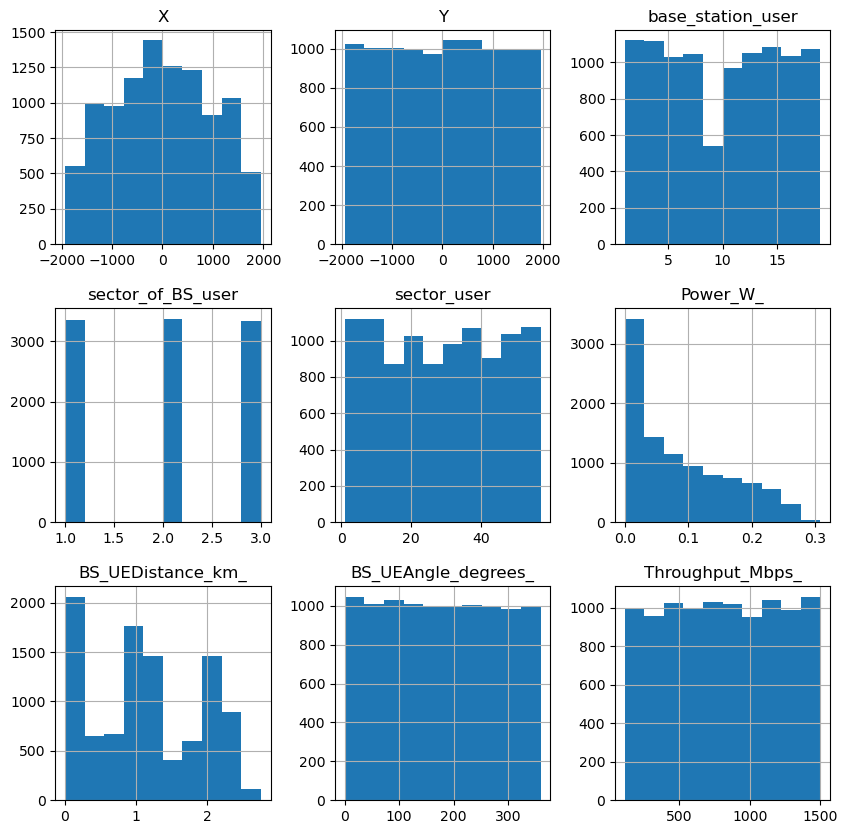

In [8]:
_ = df.hist(figsize=(10, 10))

We will investigate linear dependencies between our independent variables.

We observe that *sector_user* and *base_station_user* have a perfect spearman correlation of 1.

We must address this.

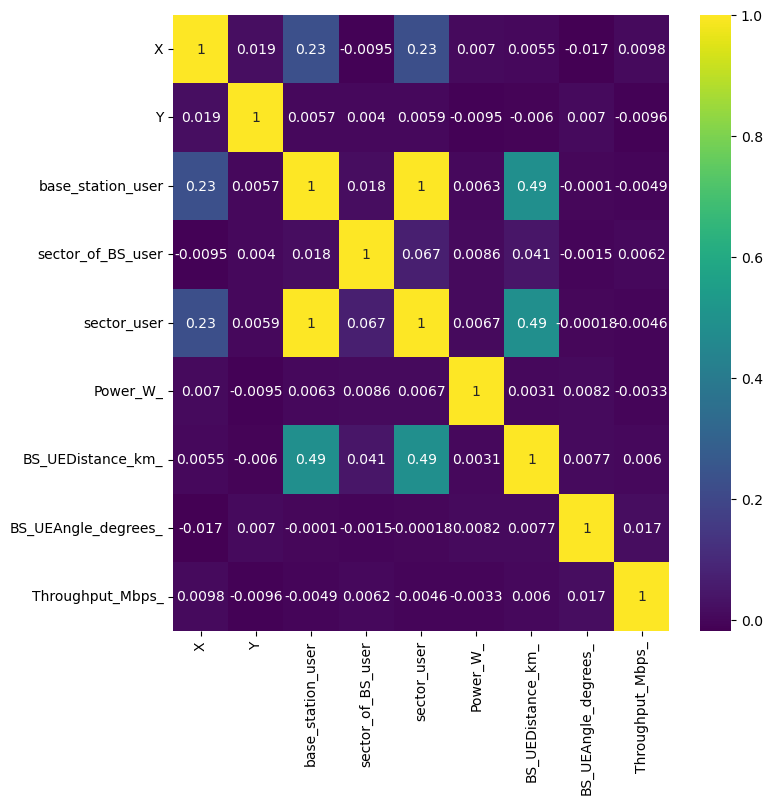

In [17]:
corr_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
_ = plt.show()

Let us visualize the relationship with a scatterplot.

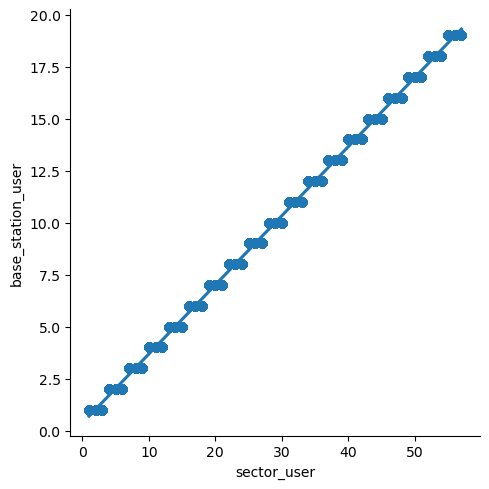

In [35]:
_ = sns.lmplot(x='sector_user', y='base_station_user', data=df)

To decide on which feature to retain and which to discard from the correlated pair *sector_user* and *base_station_user* we will fit a RandomForest model and see what feature importance does it assign to each feature.

We see that *sector_user* is more than twice as important as *base_station_user*, which hints us that we might have to remove *base_station_user*.

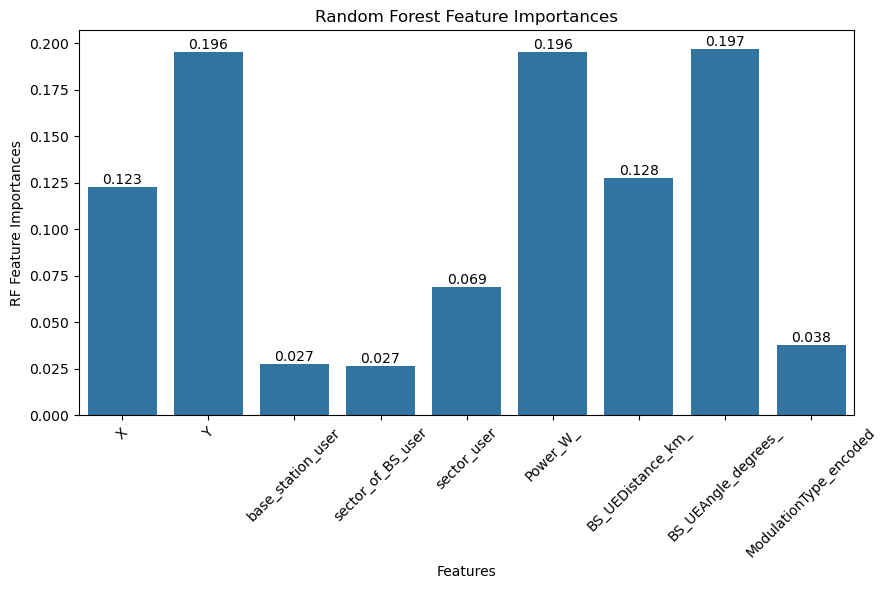

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(df.drop(columns=['Throughput_Mbps_', "ModulationType"]), y=df['Throughput_Mbps_'])

fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(
    x=df.drop(columns=['Throughput_Mbps_', "ModulationType"]).columns, 
    y=model.feature_importances_
)

for bar, importance in zip(ax.patches, model.feature_importances_):
    ax.annotate(
        f'{importance:.3f}',
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.xlabel("Features")
plt.ylabel("RF Feature Importances")
plt.title("Random Forest Feature Importances")

plt.xticks(rotation=45)
plt.show()



Another feature selection technique for correlated features is using variance as a metric and choose features with high variance.

We again observe that *sector_user* has almost 3 times as much variance as *base_station_user*

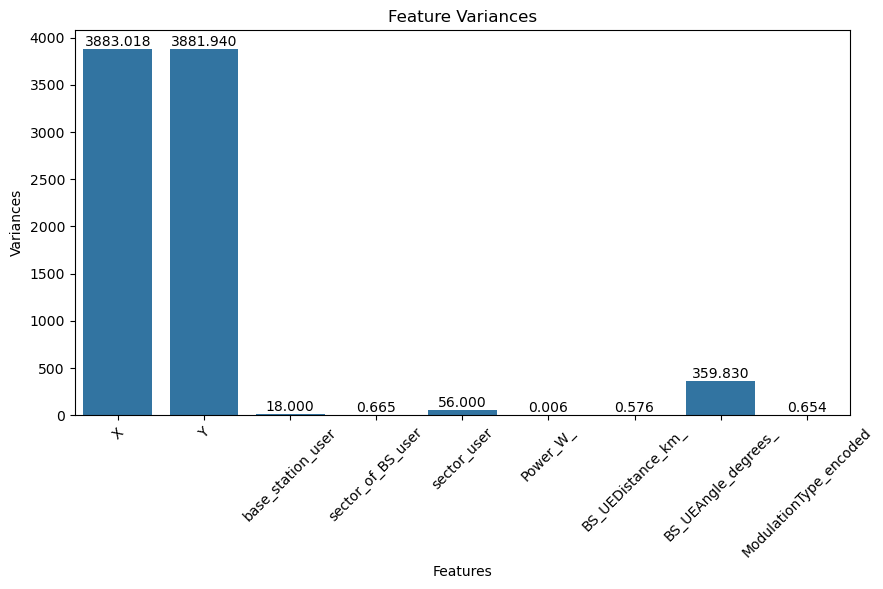

In [20]:
selector = VarianceThreshold()

variance = selector.fit_transform(df.drop(columns=['Throughput_Mbps_', "ModulationType"]))

variances = selector.variances_

fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(
    x=df.drop(columns=['Throughput_Mbps_', "ModulationType"]).columns, 
    y=selector.variances_
)

for bar, importance in zip(ax.patches, selector.variances_):
    ax.annotate(
        f'{importance:.3f}',
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.xlabel("Features")
plt.ylabel("Variances")
plt.title("Feature Variances")

plt.xticks(rotation=45)
plt.show()


Therefore we decided on retaining *sector_user* and on dropping *base_station_user*.

We see that there are no highly correlated features in our data now.

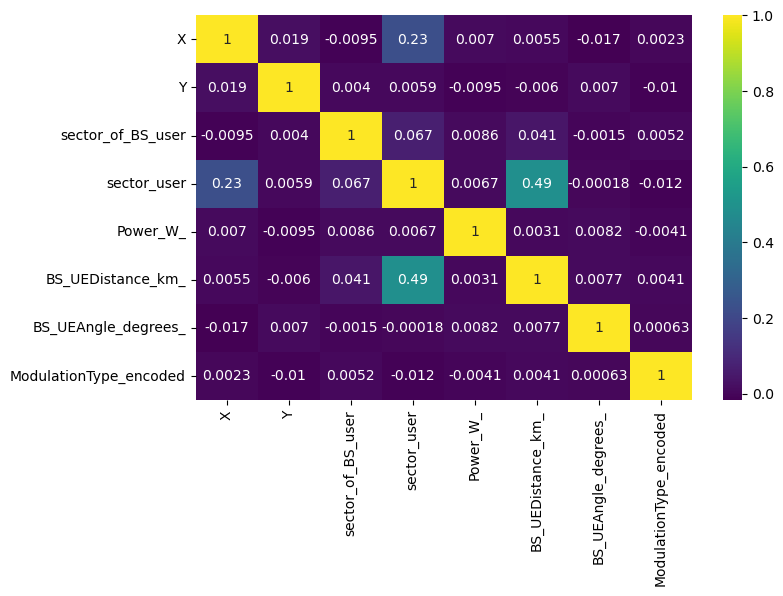

In [ ]:
df = df.drop(columns=['ModulationType', 'base_station_user'])
plt.figure(figsize=(8, 5))
_ = sns.heatmap(df.drop(columns=["Throughput_Mbps_"]).corr(), annot=True, cmap="viridis")

Split features from target

In [30]:
X = df.drop(columns='Throughput_Mbps_')
y = df['Throughput_Mbps_']